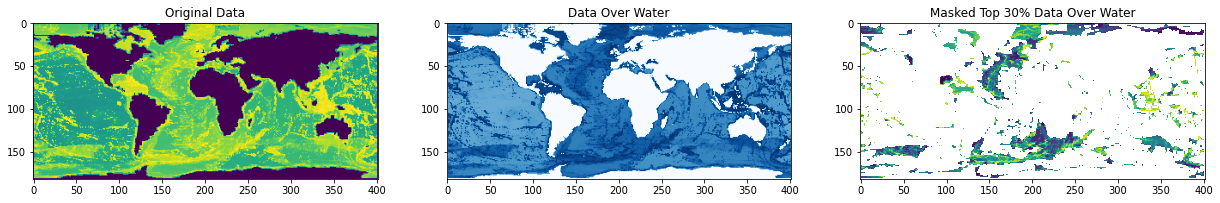

In [28]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask

# File paths
data_file_path = '../Data/Environmental_test.rank.compressed.tif'
land_shapefile_path = '../Data/ne_10m_land/ne_10m_land.shp'

# Load the environmental data
with rasterio.open(data_file_path) as src:
    data = src.read(1)  # Read the first band
    profile = src.profile  # Get the profile for writing back to a new file if needed
    raster_crs = src.crs  # Get the CRS of the raster data

# Load the land shapefile
land = gpd.read_file(land_shapefile_path)

# Ensure the land shapefile is in the same CRS as the raster data
if land.crs != raster_crs:
    land = land.to_crs(raster_crs)

# Convert the GeoDataFrame to a list of geometries
land_shapes = [geom for geom in land.geometry]

# Mask out the land areas from the raster data
with rasterio.open(data_file_path) as src:
    data_over_water, _ = mask(src, land_shapes, invert=True, crop=False)
    data_over_water = data_over_water[0]  # Get the first band

# Calculate the 70th percentile value from the data over water
threshold = np.nanpercentile(data_over_water, 70)

# Mask the values that are not in the top 30%
mask = data_over_water >= threshold

# Apply the mask to the data over water
masked_data = np.where(mask, data_over_water, np.nan)

# Optional: Save the masked data to a new file
output_file_path = 'masked_top_30_percent_over_water.tif'
with rasterio.open(output_file_path, 'w', **profile) as dst:
    dst.write(masked_data, 1)

# Plot the original, land mask, and masked data for visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
ax1.set_title('Original Data')
ax1.imshow(data, cmap='viridis')
ax2.set_title('Data Over Water')
ax2.imshow(data_over_water, cmap='Blues')
ax3.set_title('Masked Top 30% Data Over Water')
ax3.imshow(masked_data, cmap='viridis')
plt.show()


In [75]:
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterio.mask import mask
from tqdm import tqdm

# File paths
data_file_path = '../Data/Environmental_test.rank.compressed.tif'
eez_shapefile_path = '../Data/World_EEZ_v12_20231025/eez_v12.shp'

# Load the environmental data
with rasterio.open(data_file_path) as src:
    data = src.read(1)  # Read the first band
    profile = src.profile  # Get the profile for writing back to a new file if needed
    raster_crs = src.crs  # Get the CRS of the raster data
    raster_transform = src.transform  # Get the affine transform of the raster data

# Load the EEZ shapefile
eez = gpd.read_file(eez_shapefile_path)

# Ensure the EEZ shapefile is in the same CRS as the raster data
if eez.crs != raster_crs:
    eez = eez.to_crs(raster_crs)

# Prepare a list to store the results
results = []

# Iterate over each EEZ
for idx, row in tqdm(eez.iterrows(), total=eez.shape[0]):
    eez_geometry = [row['geometry']]
    country_name = row['TERRITORY1']  # Adjust this based on the attribute name in the shapefile

    # Mask the raster data with the current EEZ
#     try:
    with rasterio.open(data_file_path) as src:
        eez_masked_data, _ = mask(src, eez_geometry, crop=False, filled=False)
    eez_masked_data = eez_masked_data[0]  # Get the first band

    # Apply the top 30% mask within the EEZ, handling NaNs properly
    eez_top_30_data = np.where(np.logical_and(masked_data, ~eez_masked_data.mask),
                               1,
                               np.nan)

    # Calculate the area of the top 30% values within the EEZ
    pixel_area = abs(raster_transform[0] * raster_transform[4])  # Pixel area in map units
    eez_area = np.sum(~np.isnan(eez_top_30_data)) * pixel_area

    # Append the result to the list
    results.append({'Country': country_name, 'Area': eez_area})
#     except Exception as e:
#         print(f"Error processing {country_name}: {e}")

# Convert the results to a pandas DataFrame
df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df.to_csv('eez_top_30_percent_area.csv', index=False)

# Display the DataFrame
df


100%|█████████████████████████████████████████| 285/285 [00:57<00:00,  4.93it/s]


,Country,Area
0,American Samoa,36.086411
1,Ascension,36.888331
2,Cook Islands,165.997492
3,Falkland / Malvinas Islands,71.370902
4,French Polynesia,415.394689
...,...,...
280,Iraq,0.000000
281,Egypt,0.801920
282,Belize,0.000000
283,Norway,0.801920


In [79]:
df.sort_values("Area",ascending=False).head(10)

,Country,Area
270,Russia,1797.103280
136,Canada,1051.317448
53,Australia,632.715077
265,Greenland,539.692328
272,Alaska,538.890408
260,Indonesia,481.954070
4,French Polynesia,415.394689
241,New Zealand,404.969726
222,Japan,374.496757
268,Svalbard,329.589223


In [80]:
# Get existing MPA and overlap and see which regions are missing

In [83]:
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterio.mask import mask
from tqdm import tqdm

# File paths
data_file_path = '../Data/Environmental_test.rank.compressed.tif'
eez_shapefile_path = '../Data/World_EEZ_v12_20231025/eez_v12.shp'
mpa_shapefile_path = '../Data/WDPA_WDOECM_Jul2024_Public_1b091e2b51c258eb3b24328044a4a3d6979e00fa2029d7538aef2befd46da362_shp_0/WDPA_WDOECM_Jul2024_Public_1b091e2b51c258eb3b24328044a4a3d6979e00fa2029d7538aef2befd46da362_shp-polygons.shp'

# Load the environmental data
with rasterio.open(data_file_path) as src:
    data = src.read(1)  # Read the first band
    profile = src.profile  # Get the profile for writing back to a new file if needed
    raster_crs = src.crs  # Get the CRS of the raster data
    raster_transform = src.transform  # Get the affine transform of the raster data

# Load the EEZ shapefile
eez = gpd.read_file(eez_shapefile_path)

# Ensure the EEZ shapefile is in the same CRS as the raster data
if eez.crs != raster_crs:
    eez = eez.to_crs(raster_crs)

# Load the MPA shapefile
mpa = gpd.read_file(mpa_shapefile_path)

# Ensure the MPA shapefile is in the same CRS as the raster data
if mpa.crs != raster_crs:
    mpa = mpa.to_crs(raster_crs)

# Prepare a list to store the results
results = []

# Iterate over each EEZ
for idx, row in tqdm(eez.iterrows(), total=eez.shape[0]):
    eez_geometry = [row['geometry']]
    country_name = row['TERRITORY1']  # Adjust this based on the attribute name in the shapefile

    # Mask the raster data with the current EEZ
    with rasterio.open(data_file_path) as src:
        eez_masked_data, eez_transform = mask(src, eez_geometry, crop=False, filled=False)
    eez_masked_data = eez_masked_data[0]  # Get the first band

    # Apply the top 30% mask within the EEZ, handling NaNs properly
    eez_top_30_data = np.where(np.logical_and(masked_data, ~eez_masked_data.mask),
                               1,
                               np.nan)

    # Calculate the area of the top 30% values within the EEZ
    pixel_area = abs(raster_transform[0] * raster_transform[4])  # Pixel area in map units
    eez_area = np.sum(~np.isnan(eez_top_30_data)) * pixel_area

    # Calculate the area of the MPA within the EEZ
    mpa_in_eez = gpd.overlay(gpd.GeoDataFrame(geometry=eez_geometry, crs=raster_crs), mpa, how='intersection')
    if not mpa_in_eez.empty:
        with rasterio.open(data_file_path) as src:
            mpa_masked_data, _ = mask(src, mpa_in_eez.geometry, crop=False, filled=False)
        mpa_masked_data = mpa_masked_data[0]  # Get the first band

        # Apply the top 30% mask within the MPA area
        mpa_top_30_data = np.where(np.logical_and(masked_data, ~mpa_masked_data.mask),
                                   1,
                                   np.nan)

        # Calculate the area of the top 30% values within the MPA area
        mpa_area = np.sum(~np.isnan(mpa_top_30_data)) * pixel_area

        # Calculate the percentage of the EEZ area that is MPA and within the top 30%
        percent_mpa_in_top_30 = (mpa_area / eez_area) * 100
    else:
        percent_mpa_in_top_30 = 0

    # Append the result to the list
    results.append({'Country': country_name, 'EEZ Area (km^2)': eez_area, 'MPA in Top 30% Area (km^2)': mpa_area, 'Percent MPA in Top 30%': percent_mpa_in_top_30})

# Convert the results to a pandas DataFrame
df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df.to_csv('eez_top_30_percent_mpa_area.csv', index=False)

# Display the DataFrame
df


 27%|███████████▍                              | 78/285 [06:43<16:44,  4.85s/it]/var/folders/c2/89nqvt4n4493kmcyq52w2_7w0000gq/T/ipykernel_20157/417450354.py:72: RuntimeWarning: invalid value encountered in scalar divide
  percent_mpa_in_top_30 = (mpa_area / eez_area) * 100
 32%|█████████████▌                            | 92/285 [07:53<15:55,  4.95s/it]/var/folders/c2/89nqvt4n4493kmcyq52w2_7w0000gq/T/ipykernel_20157/417450354.py:72: RuntimeWarning: invalid value encountered in scalar divide
  percent_mpa_in_top_30 = (mpa_area / eez_area) * 100
 33%|█████████████▋                            | 93/285 [07:58<15:50,  4.95s/it]/var/folders/c2/89nqvt4n4493kmcyq52w2_7w0000gq/T/ipykernel_20157/417450354.py:72: RuntimeWarning: invalid value encountered in scalar divide
  percent_mpa_in_top_30 = (mpa_area / eez_area) * 100
 34%|██████████████▏                           | 96/285 [08:12<15:27,  4.91s/it]/var/folders/c2/89nqvt4n4493kmcyq52w2_7w0000gq/T/ipykernel_20157/417450354.py:72: RuntimeWarnin

,Country,EEZ Area (km^2),MPA in Top 30% Area (km^2),Percent MPA in Top 30%
0,American Samoa,36.086411,0.0,0.0
1,Ascension,36.888331,0.0,0.0
2,Cook Islands,165.997492,0.0,0.0
3,Falkland / Malvinas Islands,71.370902,0.0,0.0
4,French Polynesia,415.394689,0.0,0.0
...,...,...,...,...
280,Iraq,0.000000,0.0,0.0
281,Egypt,0.801920,0.0,0.0
282,Belize,0.000000,0.0,NaN
283,Norway,0.801920,0.0,0.0


In [86]:
df.sort_values("Percent MPA in Top 30%").tail(40)

,Country,EEZ Area (km^2),MPA in Top 30% Area (km^2),Percent MPA in Top 30%
219,Italy,52.124816,1.603840,3.076923
71,Panama,25.661448,0.801920,3.125000
158,Egypt,22.453767,0.801920,3.571429
132,Venezuela,36.086411,1.603840,4.444444
265,Greenland,539.692328,25.661448,4.754829
53,Australia,632.715077,30.472969,4.816223
216,Denmark,15.236485,0.801920,5.263158
86,Mauritania,14.434564,0.801920,5.555556
209,Finland,14.434564,0.801920,5.555556
268,Svalbard,329.589223,25.661448,7.785888
